<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Não-estou-a-conseguir-fazer-o-merge-desta-forma" data-toc-modified-id="Não-estou-a-conseguir-fazer-o-merge-desta-forma-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Não estou a conseguir fazer o merge desta forma</a></span></li></ul></div>

In [310]:
import pandas as pd
import numpy as np
# import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [311]:
def get_data_and_first_cleaning():
    rooth_path = '../rawdata/training/'
    failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
    locations_df = pd.read_csv(rooth_path + "wind-farm-1-locations.csv")
    logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
    metmast_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', sep=';')
    signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', sep=';')
    power_df = pd.read_csv(rooth_path + 'Power_curve.csv', sep=',')
#     costs_df = pd.read_csv(rooth_path + 'HTW_Costs.csv')
    
    # pass all the Timestamps to date-time format and set as index
    failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
    logs_df['Timestamp'] = pd.to_datetime(logs_df['TimeDetected'])
    logs_df = logs_df.drop(columns=['TimeDetected','UnitTitleDestination'])
    metmast_df['Timestamp'] = pd.to_datetime(metmast_df['Timestamp'])
    signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])
#     locations_df = locations_df.drop(columns='data_set_av')
    
    # Replace by integers Turbine_ID
    failures_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    logs_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    signals_df.replace({'T01': 1, 'T06': 6, 'T07': 7, 'T09': 9, 'T11': 11}, inplace=True)
    locations_df.replace({'Wind Turbine 1': 1, 'Wind Turbine 6': 6, 'Wind Turbine 7': 7, 
                          'Wind Turbine 9': 9, 'Wind Turbine 11': 11}, inplace=True)
    
    # Set Timestamp Columns as Index
    failures_df.set_index('Timestamp', inplace=True)
    logs_df.set_index('Timestamp', inplace=True)
    metmast_df.set_index('Timestamp', inplace=True)
    signals_df.set_index('Timestamp', inplace=True)
    
    # Drop Columns with std=0
    drop_features_metmast = ['Anemometer1_Offset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Min_Raindetection',
                             'Avg_Raindetection', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset',
                             'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 
                             'AirRessureSensorZeroOffset']
    metmast_df = metmast_df.drop(columns=drop_features_metmast)
    
    drop_features_signals = ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2']
    signals_df = signals_df.drop(columns=drop_features_signals)
    
    # interpolate to fill NA
    metmast_df = metmast_df.interpolate()
    signals_df = signals_df.interpolate()
    
    return failures_df, locations_df, logs_df, metmast_df, signals_df, power_df

In [312]:
failures_df, locations_df, logs_df, metmast_df, signals_df, power_df = get_data_and_first_cleaning()

In [313]:
logs_df.head()

,TimeReset,UnitTitle,Remark
Timestamp,,,
2016-01-01 00:02:18+00:00,NaN,11,External power ref.:2000kW
2016-01-01 00:07:15+00:00,NaN,6,Generator 1 in
2016-01-01 00:11:33+00:00,NaN,9,External power ref.:2000kW
2016-01-01 00:15:27+00:00,NaN,1,Generator 1 in
2016-01-01 00:15:44+00:00,NaN,1,External power ref.:2000kW


In [314]:
metmast_df_2016 = metmast_df #.loc[metmast_df.index < '2017']
signals_df_2016 = signals_df #.loc[signals_df.index < '2017']

In [315]:
signals_df_2016.shape, metmast_df_2016.shape

((434145, 80), (69961, 29))

In [316]:
#Function to merge Signals and Metmast - just year of 2016
def merge_data_frames():
    merge_signals_metmast = pd.merge_asof(signals_df_2016, metmast_df_2016, left_index=True, right_index=True)
    
    return merge_signals_metmast

In [317]:
merge_signals_metmast = merge_data_frames()

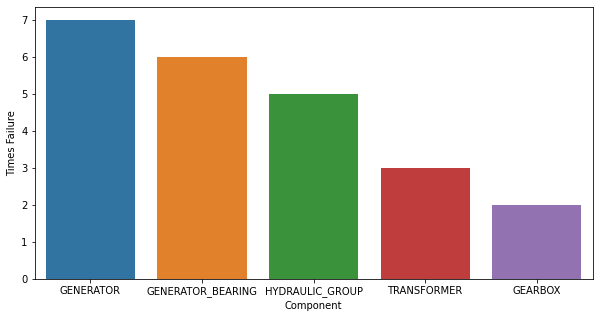

In [318]:
#Number of failures by each component
fig = plt.figure(figsize=(10,5))
nu = failures_df['Component'].value_counts().reset_index()
nu.columns = ['Component','Times Failure']
ax = sns.barplot(x='Component', y='Times Failure', data=nu)

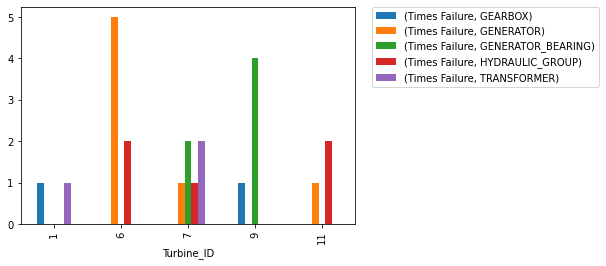

In [319]:
#Failures of components by Turbine
failures_df_by_turbine = failures_df.groupby(['Turbine_ID'])['Component'].value_counts()
failures_df_by_turbine = failures_df_by_turbine.to_frame()
failures_df_by_turbine.columns = ['Times Failure']
temp = failures_df_by_turbine.unstack()
temp.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

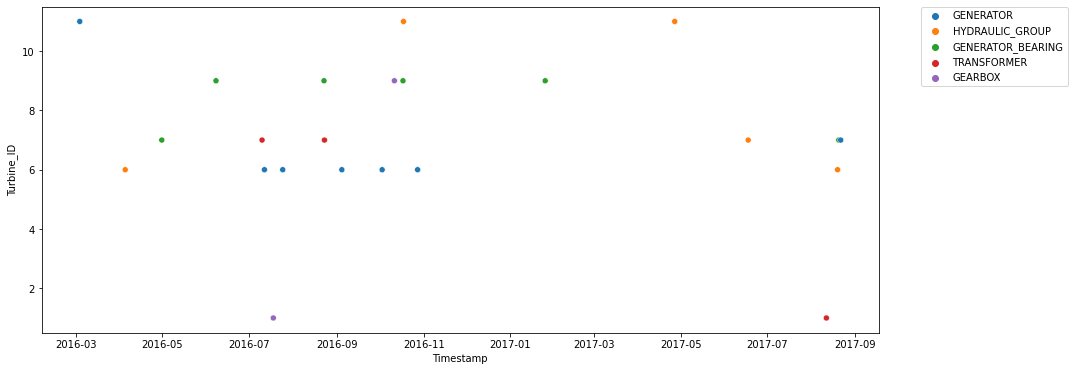

In [320]:
#Failures by component and Turbine across time
turbine_id_list = failures_df['Turbine_ID'].tolist()
component_id_list = failures_df['Component'].tolist()

fig = plt.figure(figsize=(15,6))
sns.scatterplot(x=failures_df.index, y=turbine_id_list, hue=component_id_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Turbine_ID')
plt.xlabel('Timestamp')
plt.show()

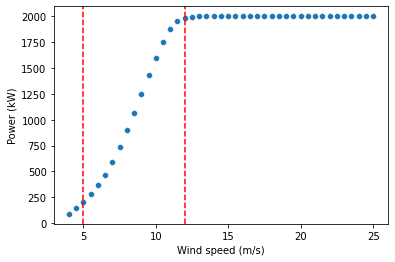

In [321]:
# Three Different phases of the turbines
sns.scatterplot(x=power_df['Wind speed (m/s)'], y=power_df['Power (kW)'])
plt.axvline(x=5, color='red', linestyle= '--')
plt.axvline(x=12, color='red', linestyle= '--')

By Research:

• Region 1: Includes the time when the turbine is starting up;

• Region 2: Operational region in which it is desirable to seize as much wind power as possible;

• Region 3: Wind speeds are relatively high (rated wind speed) and force the turbine to limit the fraction of wind power captured, for electrical and mechanical safety.

In [322]:
#Funtion to analyse by turbine
def turbine(turbine_id, df):
    new_df = df[df['Turbine_ID'] == turbine_id].sort_index(ascending=True)
    return new_df

In [323]:
# Function to find str in columns of df
def component(component, col):
    pair_comp_col=[]
    for i in col:
        if component in i:
            pair_comp_col.append(i)
    return pair_comp_col

In [324]:
# Function to analyse by component
def component_df(component, df):
    df_component = df[df['Component'] == component].sort_index(ascending=True)
    return df_component

In [325]:
#signals of each turbines
t1_df = turbine(1, signals_df)
t6_df = turbine(6, signals_df)
t7_df = turbine(7, signals_df)
t9_df = turbine(9, signals_df)
t11_df = turbine(11, signals_df)

In [326]:
#Failures of each turbines
t1_failures = turbine(1, failures_df)
t6_failures = turbine(6, failures_df)
t7_failures = turbine(7, failures_df)
t9_failures = turbine(9, failures_df)
t11_failures = turbine(11, failures_df)

In [327]:
#Failures of each component
df_generator_failures = component_df('GENERATOR', failures_df)
df_hydraulic_failures = component_df('HYDRAULIC_GROUP', failures_df)
df_bearing_failures = component_df('GENERATOR_BEARING', failures_df)
df_gearbox_failures = component_df('GEARBOX', failures_df)
df_transformer_failures = component_df('TRANSFORMER', failures_df)

In [328]:
pair_gen = component('Gen', signals_df.columns)

In [329]:
pair_gear = component('Gear', signals_df.columns)
pair_gear

['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg']

In [330]:
pair_trafo = component('Trafo', signals_df.columns)
pair_trafo

['HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg']

In [331]:
pair_hyd = component('Hyd', signals_df.columns)
pair_hyd

['Hyd_Oil_Temp_Avg']

In [332]:
df_generator_failures.head()

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-03-03 19:00:00+00:00,11,GENERATOR,Electric circuit error in generator
2016-07-11 19:48:00+00:00,6,GENERATOR,Generator replaced
2016-07-24 17:01:00+00:00,6,GENERATOR,Generator temperature sensor failure
2016-09-04 08:08:00+00:00,6,GENERATOR,High temperature generator error
2016-10-02 17:08:00+00:00,6,GENERATOR,Refrigeration system and temperature sensors i...


# Analysing by Component

In [333]:
# I THINK METEREOLOGICAL DF IS REDUDANT. WIND SPEED IS VERY IMPORTANT BUT IS ALSO ALREADY IN SIGNALS DF. AMB TEMP ALSO
# Let's only focus on signals_df_2016
# Create datasets for each component and label by chosing the correct input variables


# Since we don't know if the other variables are related to the failures, we will also take them in consideration
# Didn't count with "production" - output and most of "grid"
pair_rot = component('Rtr', signals_df.columns)
pair_amb = component('Amb', signals_df.columns)
pair_blds = component('Blds', signals_df.columns)
pair_cont = component('Cont', signals_df.columns)
pair_nac = component('Nac', signals_df.columns)
pair_spin = component('Spin', signals_df.columns)
pair_bus = component('Busbar', signals_df.columns)

In [334]:
temp = signals_df_2016[['Turbine_ID']]

In [335]:
df_signals_generator = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_gen_bear = signals_df_2016[pair_gen + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
df_signals_transformer = signals_df_2016[pair_trafo + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_hydraulic = signals_df_2016[pair_hyd + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
df_signals_gearbox = signals_df_2016[pair_gear + pair_rot + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]

In [336]:
df_signals_generator['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gen_bear['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_transformer['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_hydraulic['Turbine_ID'] = temp['Turbine_ID'].to_numpy()
df_signals_gearbox['Turbine_ID'] = temp['Turbine_ID'].to_numpy()

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [337]:
# Classification label
failures_generator = failures_df[failures_df['Component'] == 'GENERATOR']
failures_generator.replace('GENERATOR', 1, inplace=True)
failures_gen_bear = failures_df[failures_df['Component'] == 'GENERATOR_BEARING']
failures_gen_bear.replace('GENERATOR_BEARING', 1, inplace=True)
failures_hyd = failures_df[failures_df['Component'] == 'HYDRAULIC_GROUP']
failures_hyd.replace('HYDRAULIC_GROUP', 1, inplace=True)
failures_gearbox = failures_df[failures_df['Component'] == 'GEARBOX']
failures_gearbox.replace('GEARBOX', 1, inplace=True)
failures_transf = failures_df[failures_df['Component'] == 'TRANSFORMER']
failures_transf.replace('TRANSFORMER', 1, inplace=True)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/pandas/core/frame.py:4527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [338]:
failures_generator_2016 = failures_generator #.loc[failures_generator.index < '2017']
failures_gen_bear_2016 = failures_gen_bear #.loc[failures_gen_bear.index < '2017']
failures_hyd_2016 = failures_hyd #.loc[failures_hyd.index < '2017']
failures_gearbox_2016 = failures_gearbox #.loc[failures_gearbox.index < '2017']
failures_transf_2016 = failures_transf #.loc[failures_transf.index < '2017']

In [339]:
failures_generator_2016

,Turbine_ID,Component,Remarks
Timestamp,,,
2016-03-03 19:00:00+00:00,11,1,Electric circuit error in generator
2016-07-11 19:48:00+00:00,6,1,Generator replaced
2016-07-24 17:01:00+00:00,6,1,Generator temperature sensor failure
2016-09-04 08:08:00+00:00,6,1,High temperature generator error
2016-10-02 17:08:00+00:00,6,1,Refrigeration system and temperature sensors i...
2016-10-27 16:26:00+00:00,6,1,Generator replaced
2017-08-21 14:47:00+00:00,7,1,Generator damaged


In [340]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [341]:
#df_signals_generator_final = pd.merge_asof(df_signals_generator, failures_generator_2016, 
 #                                          left_by='Timestamp', right_by='Timestamp', on = 'Turbine_ID', 
  #                                         direction='nearest')
#df_signals_gen_bear_final = pd.merge_asof(df_signals_gen_bear, failures_gen_bear_2016, 
#                                           left_index=True, right_index=True,  left_by='Turbine_ID', right_by='Turbine_ID',
#                                          tolerance=pd.Timedelta("5m"))
#df_signals_hyd_final = pd.merge_asof(df_signals_hydraulic, failures_hyd_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_gearbox_final = pd.merge_asof(df_signals_gearbox, failures_gearbox_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))
#df_signals_transf_final = pd.merge_asof(df_signals_transformer, failures_transf_2016, 
#                                           left_index=True, right_index=True, by='Turbine_ID', tolerance=pd.Timedelta("1d"))

##### Não estou a conseguir fazer o merge desta forma

In [342]:
#Reset Index to merge df
df_signals_generator.reset_index(inplace=True)
df_signals_gen_bear.reset_index(inplace=True)
df_signals_transformer.reset_index(inplace=True)
df_signals_hydraulic.reset_index(inplace=True)
df_signals_gearbox.reset_index(inplace=True)
failures_generator_2016.reset_index(inplace=True)
failures_gen_bear_2016.reset_index(inplace=True)
failures_hyd_2016.reset_index(inplace=True)
failures_gearbox_2016.reset_index(inplace=True)
failures_transf_2016.reset_index(inplace=True)

In [343]:
df_signals_generator_final = df_signals_generator.merge(failures_generator_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gen_bear_final = df_signals_gen_bear.merge(failures_gen_bear_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_hyd_final = df_signals_hydraulic.merge(failures_hyd_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_gearbox_final = df_signals_gearbox.merge(failures_gearbox_2016, on=['Timestamp', 'Turbine_ID'], how='outer')
df_signals_transf_final = df_signals_transformer.merge(failures_transf_2016, on=['Timestamp', 'Turbine_ID'], how='outer')

In [344]:
#Drop Remarks, index_x, index_y Columns
df_signals_generator_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gen_bear_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_hyd_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_gearbox_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)
df_signals_transf_final.drop(columns=['Remarks', 'index_x', 'index_y'], inplace=True)

In [345]:
#Fill na on component column
df_signals_generator_final['Component'].fillna(0, inplace=True)
df_signals_gen_bear_final['Component'].fillna(0, inplace=True)
df_signals_hyd_final['Component'].fillna(0, inplace=True)
df_signals_gearbox_final['Component'].fillna(0, inplace=True)
df_signals_transf_final['Component'].fillna(0, inplace=True)

In [346]:
# Set Timestamp as Index
df_signals_generator_final.set_index('Timestamp', inplace=True)
df_signals_gen_bear_final.set_index('Timestamp', inplace=True)
df_signals_hyd_final.set_index('Timestamp', inplace=True)
df_signals_gearbox_final.set_index('Timestamp', inplace=True)
df_signals_transf_final.set_index('Timestamp', inplace=True)

In [347]:
# Sort Index
df_signals_generator_final.sort_index(inplace=True)
df_signals_gen_bear_final.sort_index(inplace=True)                                      
df_signals_hyd_final.sort_index(inplace=True)
df_signals_gearbox_final.sort_index(inplace=True)
df_signals_transf_final.sort_index(inplace=True)

In [348]:
# Fill na by interpolate
df_signals_generator_final = df_signals_generator_final.interpolate()
df_signals_gen_bear_final = df_signals_gen_bear_final.interpolate()
df_signals_hyd_final = df_signals_hyd_final.interpolate()
df_signals_gearbox_final = df_signals_gearbox_final.interpolate()
df_signals_transf_final = df_signals_transf_final.interpolate()

In [349]:
#Checking null values in DF's
print(df_signals_generator_final.isnull().values.any())
print(df_signals_gearbox_final.isnull().values.any())
print(df_signals_gen_bear_final.isnull().values.any())
print(df_signals_hyd_final.isnull().values.any())
print(df_signals_transf_final.isnull().values.any())

False
False
False
False
False


In [350]:
# DROP ROWS OF TURBINES WHERE IS NO FAILURES ASSOCIATED

# Base Model for Generator Failures 2016

In [351]:
X = df_signals_generator_final.drop(columns='Component')
y = df_signals_generator_final['Component']

In [352]:
### Split Train and Test
#split = int(len(X)*0.8)
#X_train, X_test = X[:split], X[split:] 
#y_train, y_test = y[:split], y[split:]

In [353]:
#Standard Scaler
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [354]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
#rnd_clf.fit(X_train, y_train)

In [355]:
#y_pred_test = rnd_clf.predict(X_test)

In [356]:
#accuracy_score(y_test, y_pred_test)

# Label RUL

In [357]:
# Creating DF's for Regression Problem Approach
df_signals_gearbox_final.shape, df_signals_generator_final.shape, df_signals_gen_bear_final.shape, df_signals_hyd_final.shape, df_signals_transf_final.shape

((434146, 32), (434152, 44), (434150, 44), (434150, 31), (434148, 33))

In [358]:
df_signals_generator_final['Turbine_ID'].value_counts()

11    87249
7     87208
9     87156
1     87146
6     85393
Name: Turbine_ID, dtype: int64

# DF RUL Failures Generator

In [359]:
df_signals_generator_final = df_signals_generator_final.groupby(by=['Timestamp','Turbine_ID']).mean()

In [360]:
df_signals_generator_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)

In [361]:
df_signals_generator_final.reset_index(inplace=True)

In [362]:
#DF Signals Generator failures on turbine 6 and 11 in 2016
df_signals_generator_t6 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 6]
df_signals_generator_t11 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 11]
df_signals_generator_t7 = df_signals_generator_final[df_signals_generator_final['Turbine_ID'] == 7]

In [363]:
index_list = df_signals_generator_t6.loc[df_signals_generator_t6['Component'] == 1]

In [364]:
index_list['date'] = index_list['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [365]:
index_list = index_list[['Timestamp','date']]

In [366]:
df = df_signals_generator_t6.merge(index_list, on=['Timestamp'], how='left')

In [367]:
df_generator_t6 = df.fillna(method='bfill')

In [368]:
df_generator_t6['TTF'] = df_generator_t6['date'] - df_generator_t6['Timestamp'] 

In [369]:
df_generator_t6 = df_generator_t6.drop(columns='date')

In [370]:
index_list_t11 = df_signals_generator_t11.loc[df_signals_generator_t11['Component'] == 1]

In [371]:
index_list_t11['date'] = index_list_t11['Timestamp']

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [372]:
index_list_t11 = index_list_t11[['Timestamp','date']]

In [373]:
df = df_signals_generator_t11.merge(index_list_t11, on=['Timestamp'], how='left')

In [374]:
df_generator_t11 = df.fillna(method='bfill')

In [375]:
df_generator_t11['TTF'] = df_generator_t11['date'] - df_generator_t11['Timestamp'] 

In [376]:
df_generator_t11 = df_generator_t11.drop(columns='date')

In [377]:
df_generator_t11.shape, df_generator_t6.shape

((87243, 46), (85387, 46))

In [378]:
index_list_t7 = df_signals_generator_t7.loc[df_signals_generator_t7['Component'] == 1]
index_list_t7['date'] = index_list_t7['Timestamp']
index_list_t7 = index_list_t7[['Timestamp','date']]
df = df_signals_generator_t7.merge(index_list_t7, on=['Timestamp'], how='left')
df_generator_t7 = df.fillna(method='bfill')
df_generator_t7['TTF'] = df_generator_t7['date'] - df_generator_t7['Timestamp'] 
df_generator_t7 = df_generator_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [379]:
generator_final = pd.concat([df_generator_t6, df_generator_t7, df_generator_t11])

In [380]:
generator_final

,Timestamp,Turbine_ID,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,6,1270.0,1232.8,1248.5,6.8,42.0,51.0,52.0,53.0,...,28.0,38.0,96.0,38.0,29.0,204.6,20.0,37.0,0.0,192 days 19:48:00
1,2016-01-01 00:10:00+00:00,6,1429.7,203.9,1154.1,271.7,42.0,51.0,52.0,52.0,...,28.0,38.0,96.0,37.0,29.0,210.5,20.0,37.0,0.0,192 days 19:38:00
2,2016-01-01 00:20:00+00:00,6,1360.5,250.3,1041.4,382.7,42.0,50.0,51.0,51.0,...,27.0,38.0,93.0,39.0,29.0,199.0,20.0,37.0,0.0,192 days 19:28:00
3,2016-01-01 00:30:00+00:00,6,1399.2,1228.8,1252.5,16.5,42.0,49.0,50.0,50.0,...,27.0,38.0,92.0,39.0,29.0,205.6,20.0,37.0,0.0,192 days 19:18:00
4,2016-01-01 00:40:00+00:00,6,1302.7,1225.1,1257.6,13.4,41.0,50.0,50.0,51.0,...,27.0,38.0,94.0,38.0,29.0,207.4,20.0,37.0,0.0,192 days 19:08:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87238,2017-08-31 23:20:00+00:00,11,1434.3,1243.1,1286.1,46.8,43.0,56.0,57.0,56.0,...,34.0,44.0,70.0,40.0,31.0,117.5,28.0,40.0,0.0,NaT
87239,2017-08-31 23:30:00+00:00,11,1265.2,1238.6,1249.8,4.1,43.0,57.0,58.0,58.0,...,34.0,44.0,73.0,40.0,31.0,117.5,28.0,41.0,0.0,NaT
87240,2017-08-31 23:40:00+00:00,11,1264.6,1235.1,1248.8,4.7,44.0,58.0,59.0,59.0,...,33.0,44.0,76.0,39.0,31.0,116.0,28.0,41.0,0.0,NaT
87241,2017-08-31 23:50:00+00:00,11,1281.4,1231.9,1250.5,6.3,45.0,59.0,60.0,60.0,...,33.0,45.0,78.0,39.0,31.0,102.9,28.0,41.0,0.0,NaT


# DF RUL Failures Gen Bear

In [381]:
df_signals_gen_bear_final = df_signals_gen_bear_final.groupby(by=['Timestamp','Turbine_ID']).mean()

In [382]:
df_signals_gen_bear_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)

In [383]:
df_signals_gen_bear_final.reset_index(inplace=True)

In [384]:
#DF Signals Generator failures on turbine 7 and 9 in 2016
df_signals_gen_bear_t7 = df_signals_gen_bear_final[df_signals_gen_bear_final['Turbine_ID'] == 7]
df_signals_gen_bear_t9 = df_signals_gen_bear_final[df_signals_gen_bear_final['Turbine_ID'] == 9]

In [385]:
index_list = df_signals_gen_bear_t7.loc[df_signals_gen_bear_t7['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_gen_bear_t7.merge(index_list, on=['Timestamp'], how='left')
df_gen_bear_t7 = df.fillna(method='bfill')
df_gen_bear_t7['TTF'] = df_gen_bear_t7['date'] - df_gen_bear_t7['Timestamp'] 
df_gen_bear_t7 = df_gen_bear_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [386]:
index_list_t9 = df_signals_gen_bear_t9.loc[df_signals_gen_bear_t9['Component'] == 1]
index_list_t9['date'] = index_list_t9['Timestamp']
index_list_t9 = index_list_t9[['Timestamp','date']]
df = df_signals_gen_bear_t9.merge(index_list_t9, on=['Timestamp'], how='left')
df_gen_bear_t9 = df.fillna(method='bfill')
df_gen_bear_t9['TTF'] = df_gen_bear_t9['date'] - df_gen_bear_t9['Timestamp'] 
df_gen_bear_t9 = df_gen_bear_t9.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [387]:
gen_bear_final = pd.concat([df_gen_bear_t7, df_gen_bear_t9])

# DF RUL Failures Hydraulic

In [388]:
df_signals_hyd_final = df_signals_hyd_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_hyd_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_hyd_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 6 and 11 in 2016
df_signals_hyd_t6 = df_signals_hyd_final[df_signals_hyd_final['Turbine_ID'] == 6]
df_signals_hyd_t7 = df_signals_hyd_final[df_signals_hyd_final['Turbine_ID'] == 7]
df_signals_hyd_t11 = df_signals_hyd_final[df_signals_hyd_final['Turbine_ID'] == 11]

In [389]:
index_list = df_signals_hyd_t11.loc[df_signals_hyd_t11['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_hyd_t11.merge(index_list, on=['Timestamp'], how='left')
df_hyd_t11 = df.fillna(method='bfill')
df_hyd_t11['TTF'] = df_hyd_t11['date'] - df_hyd_t11['Timestamp'] 
df_hyd_t11 = df_hyd_t11.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [390]:
index_list_t6 = df_signals_hyd_t6.loc[df_signals_hyd_t6['Component'] == 1]
index_list_t6['date'] = index_list_t6['Timestamp']
index_list_t6 = index_list_t6[['Timestamp','date']]
df = df_signals_hyd_t6.merge(index_list_t6, on=['Timestamp'], how='left')
df_hyd_t6 = df.fillna(method='bfill')
df_hyd_t6['TTF'] = df_hyd_t6['date'] - df_hyd_t6['Timestamp'] 
df_hyd_t6 = df_hyd_t6.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [391]:
index_list_t7 = df_signals_hyd_t7.loc[df_signals_hyd_t7['Component'] == 1]
index_list_t7['date'] = index_list_t7['Timestamp']
index_list_t7 = index_list_t7[['Timestamp','date']]
df = df_signals_hyd_t7.merge(index_list_t7, on=['Timestamp'], how='left')
df_hyd_t7 = df.fillna(method='bfill')
df_hyd_t7['TTF'] = df_hyd_t7['date'] - df_hyd_t7['Timestamp'] 
df_hyd_t7 = df_hyd_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [392]:
hyd_final = pd.concat([df_hyd_t6, df_hyd_t7, df_hyd_t11])

In [393]:
hyd_final

,Timestamp,Turbine_ID,Hyd_Oil_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,Rtr_RPM_Std,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,6,30.0,11.2,10.9,11.1,40.0,40.0,38.0,0.1,...,28.0,38.0,96.0,38.0,29.0,204.6,20.0,37.0,0.0,94 days 18:53:00
1,2016-01-01 00:10:00+00:00,6,30.0,12.6,2.0,10.2,38.0,38.0,36.0,2.4,...,28.0,38.0,96.0,37.0,29.0,210.5,20.0,37.0,0.0,94 days 18:43:00
2,2016-01-01 00:20:00+00:00,6,31.0,12.0,2.3,9.2,39.0,39.0,37.0,3.4,...,27.0,38.0,93.0,39.0,29.0,199.0,20.0,37.0,0.0,94 days 18:33:00
3,2016-01-01 00:30:00+00:00,6,31.0,12.2,10.9,11.1,40.0,40.0,38.0,0.1,...,27.0,38.0,92.0,39.0,29.0,205.6,20.0,37.0,0.0,94 days 18:23:00
4,2016-01-01 00:40:00+00:00,6,31.0,11.5,10.9,11.1,40.0,40.0,38.0,0.1,...,27.0,38.0,94.0,38.0,29.0,207.4,20.0,37.0,0.0,94 days 18:13:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87239,2017-08-31 23:20:00+00:00,11,40.0,12.7,11.0,11.4,40.0,41.0,41.0,0.4,...,34.0,44.0,70.0,40.0,31.0,117.5,28.0,40.0,0.0,NaT
87240,2017-08-31 23:30:00+00:00,11,40.0,11.2,10.9,11.1,40.0,41.0,41.0,0.0,...,34.0,44.0,73.0,40.0,31.0,117.5,28.0,41.0,0.0,NaT
87241,2017-08-31 23:40:00+00:00,11,40.0,11.2,10.9,11.1,39.0,40.0,40.0,0.0,...,33.0,44.0,76.0,39.0,31.0,116.0,28.0,41.0,0.0,NaT
87242,2017-08-31 23:50:00+00:00,11,40.0,11.4,10.9,11.1,39.0,40.0,40.0,0.1,...,33.0,45.0,78.0,39.0,31.0,102.9,28.0,41.0,0.0,NaT


# DF RUL Failures GearBox

In [394]:
df_signals_gearbox_final = df_signals_gearbox_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_gearbox_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_gearbox_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 1 and 9 in 2016
df_signals_gearbox_t1 = df_signals_gearbox_final[df_signals_gearbox_final['Turbine_ID'] == 1]
df_signals_gearbox_t9 = df_signals_gearbox_final[df_signals_gearbox_final['Turbine_ID'] == 9]

In [395]:
df_signals_gearbox_t1.loc[df_signals_gearbox_t1['Component'] == 1,'Timestamp']
# df_signals_gearbox_t1 = df_signals_gearbox_t1.truncate(after=28632)

28632   2016-07-18 02:10:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [396]:
df_signals_gearbox_t9.loc[df_signals_gearbox_t9['Component'] == 1,'Timestamp']
# df_signals_gearbox_t9 = df_signals_gearbox_t9.truncate(after=196073)

300355   2016-10-11 08:06:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [397]:
index_list = df_signals_gearbox_t1.loc[df_signals_gearbox_t1['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_gearbox_t1.merge(index_list, on=['Timestamp'], how='left')
df_gearbox_t1 = df.fillna(method='bfill')
df_gearbox_t1['TTF'] = df_gearbox_t1['date'] - df_gearbox_t1['Timestamp'] 
df_gearbox_t1 = df_gearbox_t1.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [398]:
index_list_t9 = df_signals_gearbox_t9.loc[df_signals_gearbox_t9['Component'] == 1]
index_list_t9['date'] = index_list_t9['Timestamp']
index_list_t9 = index_list_t9[['Timestamp','date']]
df = df_signals_gearbox_t9.merge(index_list_t9, on=['Timestamp'], how='left')
df_gearbox_t9 = df.fillna(method='bfill')
df_gearbox_t9['TTF'] = df_gearbox_t9['date'] - df_gearbox_t9['Timestamp'] 
df_gearbox_t9 = df_gearbox_t9.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [399]:
gearbox_final = pd.concat([df_gearbox_t1, df_gearbox_t9])

In [400]:
gearbox_final

,Timestamp,Turbine_ID,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Rtr_RPM_Max,Rtr_RPM_Min,Rtr_RPM_Avg,Grd_RtrInvPhase1_Temp_Avg,Grd_RtrInvPhase2_Temp_Avg,Grd_RtrInvPhase3_Temp_Avg,...,Cont_Hub_Temp_Avg,Cont_VCP_Temp_Avg,Cont_VCP_ChokcoilTemp_Avg,Cont_VCP_WtrTemp_Avg,Nac_Temp_Avg,Nac_Direction_Avg,Spin_Temp_Avg,Grd_Busbar_Temp_Avg,Component,TTF
0,2016-01-01 00:00:00+00:00,1,44.0,48.0,11.3,10.9,11.1,39.0,39.0,38.0,...,28.0,43.0,91.0,39.0,28.0,218.5,20.0,38.0,0.0,199 days 02:10:00
1,2016-01-01 00:10:00+00:00,1,44.0,48.0,11.2,0.0,8.8,37.0,36.0,37.0,...,28.0,42.0,91.0,37.0,28.0,218.5,20.0,38.0,0.0,199 days 02:00:00
2,2016-01-01 00:20:00+00:00,1,43.0,46.0,12.3,1.9,6.8,38.0,37.0,37.0,...,28.0,42.0,87.0,38.0,29.0,213.3,20.0,38.0,0.0,199 days 01:50:00
3,2016-01-01 00:30:00+00:00,1,44.0,48.0,11.5,10.7,11.1,38.0,38.0,38.0,...,28.0,42.0,87.0,38.0,28.0,222.4,20.0,38.0,0.0,199 days 01:40:00
4,2016-01-01 00:40:00+00:00,1,44.0,48.0,11.7,10.8,11.1,39.0,38.0,38.0,...,28.0,42.0,88.0,39.0,28.0,222.4,20.0,38.0,0.0,199 days 01:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87146,2017-08-31 23:20:00+00:00,9,48.0,53.0,11.1,10.8,11.0,40.0,41.0,40.0,...,33.0,44.0,65.0,38.0,35.0,124.9,27.0,39.0,0.0,NaT
87147,2017-08-31 23:30:00+00:00,9,48.0,51.0,11.2,2.3,10.1,39.0,40.0,39.0,...,33.0,44.0,66.0,38.0,35.0,114.5,26.0,39.0,0.0,NaT
87148,2017-08-31 23:40:00+00:00,9,47.0,49.0,12.3,2.7,10.4,40.0,41.0,41.0,...,33.0,44.0,65.0,39.0,35.0,110.5,26.0,39.0,0.0,NaT
87149,2017-08-31 23:50:00+00:00,9,47.0,50.0,11.2,10.9,11.0,40.0,41.0,40.0,...,33.0,44.0,67.0,38.0,34.0,101.9,26.0,39.0,0.0,NaT


# DF RUL Failures Transformer

In [401]:
df_signals_transf_final = df_signals_transf_final.groupby(by=['Timestamp','Turbine_ID']).mean()
df_signals_transf_final.sort_values(['Turbine_ID','Timestamp'], inplace=True)
df_signals_transf_final.reset_index(inplace=True)
#DF Signals Generator failures on turbine 7 in 2016
df_signals_transf_t7 = df_signals_transf_final[df_signals_transf_final['Turbine_ID'] == 7]
df_signals_transf_t1 = df_signals_transf_final[df_signals_transf_final['Turbine_ID'] == 1]

In [402]:
index_list = df_signals_transf_t7.loc[df_signals_transf_t7['Component'] == 1]
index_list['date'] = index_list['Timestamp']
index_list = index_list[['Timestamp','date']]
df = df_signals_transf_t7.merge(index_list, on=['Timestamp'], how='left')
df_transf_t7 = df.fillna(method='bfill')
df_transf_t7['TTF'] = df_transf_t7['date'] - df_transf_t7['Timestamp'] 
df_transf_t7 = df_transf_t7.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [403]:
index_list_t1 = df_signals_transf_t1.loc[df_signals_transf_t1['Component'] == 1]
index_list_t1['date'] = index_list_t1['Timestamp']
index_list = index_list_t1[['Timestamp','date']]
df = df_signals_transf_t1.merge(index_list, on=['Timestamp'], how='left')
df_transf_t1 = df.fillna(method='bfill')
df_transf_t1['TTF'] = df_transf_t1['date'] - df_transf_t1['Timestamp'] 
df_transf_t1 = df_transf_t1.drop(columns='date')

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [405]:
transf_final = pd.concat([df_transf_t1, df_transf_t7])

In [407]:
transf_final.shape, gearbox_final.shape, generator_final.shape, gen_bear_final.shape, hyd_final.shape

((174344, 35), (174291, 34), (259832, 46), (174356, 46), (259830, 33))

In [408]:
transf_final['TTF'] = transf_final['TTF'].dt.days
gearbox_final['TTF'] = gearbox_final['TTF'].dt.days
generator_final['TTF'] = generator_final['TTF'].dt.days
gen_bear_final['TTF'] = gen_bear_final['TTF'].dt.days
hyd_final['TTF'] = hyd_final['TTF'].dt.days

In [409]:
def Failure_Time_Horizon(days, period):
    if days <= period:
        Flag=1
    else:
        Flag=0
    return Flag

In [410]:
transf_final['60_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gearbox_final['60_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
generator_final['60_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
gen_bear_final['60_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)
hyd_final['60_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 60),axis=1)

In [411]:
transf_final['40_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gearbox_final['40_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
generator_final['40_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
gen_bear_final['40_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)
hyd_final['40_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 40),axis=1)

In [412]:
transf_final['30_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gearbox_final['30_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
generator_final['30_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
gen_bear_final['30_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)
hyd_final['30_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 30),axis=1)

In [413]:
transf_final['20_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gearbox_final['20_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
generator_final['20_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
gen_bear_final['20_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)
hyd_final['20_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 20),axis=1)

In [414]:
transf_final['10_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gearbox_final['10_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
generator_final['10_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
gen_bear_final['10_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)
hyd_final['10_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 10),axis=1)

In [415]:
transf_final['2_days'] = transf_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
gearbox_final['2_days'] = gearbox_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
generator_final['2_days'] = generator_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
gen_bear_final['2_days'] = gen_bear_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)
hyd_final['2_days'] = hyd_final.apply(lambda x: Failure_Time_Horizon(x['TTF'], 2),axis=1)

In [416]:
lista = [transf_final, gearbox_final, generator_final, gen_bear_final, hyd_final]

In [417]:
for i, df in enumerate(lista):
    lista[i] = df.fillna(0)

In [418]:
for i in lista:
    print(i['TTF'].isna().sum())

0
0
0
0
0


In [419]:
transf_final.fillna(0, inplace=True)
gearbox_final.fillna(0, inplace=True)
generator_final.fillna(0, inplace=True)
gen_bear_final.fillna(0, inplace=True)
hyd_final.fillna(0, inplace=True)

# TRAINING

In [420]:
temp = transf_final.copy()

In [421]:
temp_train = temp[temp['Timestamp'] < '2017-06-01 00:00:00+00:00']
temp_test = temp[temp['Timestamp'] >= '2017-06-01 00:00:00+00:00']

In [422]:
temp_train.columns

Index(['Timestamp', 'Turbine_ID', 'HVTrafo_Phase1_Temp_Avg',
       'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
       'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Std',
       'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg',
       'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg',
       'Amb_Temp_Avg', 'Amb_WindSpeed_Est_Avg', 'Blds_PitchAngle_Min',
       'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Cont_VCP_ChokcoilTemp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Nac_Temp_Avg',
       'Nac_Direction_Avg', 'Spin_Temp_Avg', 'Grd_Busbar_Temp_Avg',
       'Component', 'TTF', '60_days', '40_days', '30_days', '20_days',
       '10_days', '2_days'],
      dtype='object')

In [423]:
X_train_transf = temp_train.drop(columns=['Timestamp','Turbine_ID', 'TTF', '60_days', '40_days', '30_days', '20_days',
       '10_days', '2_days'])
y_train_transf = temp_train['60_days']
X_test_transf = temp_test.drop(columns=['Timestamp','Turbine_ID', 'TTF', '60_days', '40_days', '30_days', '20_days',
       '10_days', '2_days'])
y_test_transf = temp_test['60_days']

In [424]:
y_train_transf.value_counts()

0    133223
1     15087
Name: 60_days, dtype: int64

In [425]:
y_test_transf.value_counts()

0    17483
1     8551
Name: 60_days, dtype: int64

In [426]:
scaler = StandardScaler()
scaler.fit_transform(X_train_transf)
scaler.transform(X_test_transf)

array([[ 0.12297622,  0.4028775 ,  0.94803855, ...,  0.26459745,
         0.05812638, -0.00367225],
       [ 0.02290542,  0.32147336,  0.82341281, ...,  0.26459745,
         0.05812638, -0.00367225],
       [-0.07716537,  0.24006922,  0.76109994, ...,  0.26459745,
         0.31325095, -0.00367225],
       ...,
       [ 1.12368418,  0.48428164,  0.13797126, ...,  0.99067076,
         0.31325095, -0.00367225],
       [ 1.12368418,  0.48428164,  0.13797126, ...,  0.99067076,
         0.31325095, -0.00367225],
       [ 1.12368418,  0.48428164,  0.13797126, ...,  0.99067076,
         0.31325095, -0.00367225]])

In [427]:
from sklearn.linear_model import LogisticRegression

In [428]:
model = LogisticRegression()
model.fit(X_train_transf, y_train_transf)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [429]:
model.score(X_test_transf, y_test_transf)

0.5679880156718138

In [432]:
y_pred = model.predict(X_test_transf)

In [434]:
from sklearn.metrics import recall_score, roc_auc_score

In [436]:
recall_score(y_test_transf, y_pred)
#sklearn.metrics.roc_auc_score(y_test_transf, y_prob)

0.032744708221260674

In [440]:
y_prob = model.predict_proba(X_test_transf)[:,1]

In [441]:
roc_auc_score(y_test_transf, y_prob)

0.38661324026862776

In [442]:
from sklearn.metrics import confusion_matrix

In [443]:
cm2 = confusion_matrix(y_test_transf,y_pred)
total1=sum(sum(cm2))
print ('Model: Decision Tree')
print(' ')
#print('AUC_Train:   ', roc_auc_score(Y_train_balanced, tree_prob_calculadas_train))
print('AUC_Test:    ', roc_auc_score(y_test_transf, y_prob))
print('Accuracy:    ', (cm2[0,0]+cm2[1,1])/total1)
print('Sensitivity: ', cm2[1,1]/(cm2[1,0]+cm2[1,1]))
print('Specificity: ',  cm2[0,0]/(cm2[0,0]+cm2[0,1]) )
print('Precision:   ', cm2[1,1]/(cm2[0,1]+cm2[1,1]))
#print('F1 Score:    ',f1_score(Y_test_all,tree_class_calculadas_test))
#print('Log Loss:    ', log_loss(Y_test_all, tree_prob_calculadas_test))
#print('FBeta Score: ', fbeta_score(Y_test_all,tree_class_calculadas_test, beta=10))
pd.crosstab(y_test_transf, y_pred, rownames=['Actual Class'], colnames=['Predicted Class'])

Model: Decision Tree
 
AUC_Test:     0.38661324026862776
Accuracy:     0.5679880156718138
Sensitivity:  0.032744708221260674
Specificity:  0.8297774981410513
Precision:    0.085995085995086


Predicted Class,0,1
Actual Class,,
0,14507,2976
1,8271,280


In [430]:
temp['date'] = temp['Timestamp'].dt.date

In [431]:
temp.groupby(by=['date','Turbine_ID']).mean()

HVTrafo_Phase1_Temp_Avg  HVTrafo_Phase2_Temp_Avg  \
date       Turbine_ID                                                     
2016-01-01 1                         69.972222                78.430556   
           7                         72.604167                76.576389   
2016-01-02 1                         69.868056                77.979167   
           7                         73.312500                76.527778   
2016-01-03 1                         68.930556                77.805556   
...                                        ...                      ...   
2017-08-30 7                         74.908451                77.218310   
2017-08-31 1                         73.236111                77.104167   
           7                         76.965035                79.314685   
2017-09-01 1                         75.000000                80.000000   
           7                         80.000000                83.000000   

                       HVTrafo_Phase3_Temp_Avg  Rtr_RPM_Max  Rtr_RPM_Min  \
date       Turbine_ID                                                      
2016-01-01 1                         67.652778    11.095139     8.065278   
           7                         76.486111    11.557639     8.594444   
2016-01-02 1                         67.513889     5.979167     4.132639   
           7                         76.430556     6.240278     4.174306   
2016-01-03 1                         69.076389     7.997917     6.456250   
...                                        ...          ...          ...   
2017-08-30 7                         74.063380     4.095775     2.241549   
2017-08-31 1                         71.506944     8.425000     5.775694   
           7                         76.251748     6.525874     4.188112   
2017-09-01 1                         75.000000    11.400000    10.800000   
           7                         80.000000    11.400000    10.900000   

                       Rtr_RPM_Avg  Grd_RtrInvPhase1_Temp_Avg  \
date       Turbine_ID                                           
2016-01-01 1              9.651389                  37.340278   
           7             10.016667                  38.083333   
2016-01-02 1              5.104861                  33.569444   
           7              5.215972                  33.881944   
2016-01-03 1              7.403472                  35.006944   
...                            ...                        ...   
2017-08-30 7              3.208451                  34.007042   
2017-08-31 1              6.938889                  37.229167   
           7              5.097203                  35.489510   
2017-09-01 1             11.100000                  39.000000   
           7             11.100000                  39.000000   

                       Grd_RtrInvPhase2_Temp_Avg  Grd_RtrInvPhase3_Temp_Avg  \
date       Turbine_ID                                                         
2016-01-01 1                           37.006944                  36.791667   
           7                           37.944444                  39.833333   
2016-01-02 1                           33.298611                  33.236111   
           7                           33.763889                  35.527778   
2016-01-03 1                           34.965278                  34.576389   
...                                          ...                        ...   
2017-08-30 7                           33.697183                  35.366197   
2017-08-31 1                           36.826389                  36.791667   
           7                           35.286713                  37.006993   
2017-09-01 1                           39.000000                  38.000000   
           7                           39.000000                  41.000000   

                       Rtr_RPM_Std  ...  Spin_Temp_Avg  Grd_Busbar_Temp_Avg  \
date       Turbine_ID               ...                                       
2016-01-01 1              